  Epoch 0: Train Loss: 1.5574, Val Accuracy: 0.2720
  Epoch 50: Train Loss: 1.1716, Val Accuracy: 0.5550
  Epoch 100: Train Loss: 0.8982, Val Accuracy: 0.6840
  Epoch 150: Train Loss: 0.6643, Val Accuracy: 0.8850
  Epoch 200: Train Loss: 0.4525, Val Accuracy: 0.9240
  Epoch 250: Train Loss: 0.3046, Val Accuracy: 0.9890
  Epoch 300: Train Loss: 0.2311, Val Accuracy: 0.9950
  Epoch 350: Train Loss: 0.1732, Val Accuracy: 0.9950
✓ Target achieved at epoch 353
  Validation Accuracy: 1.0000


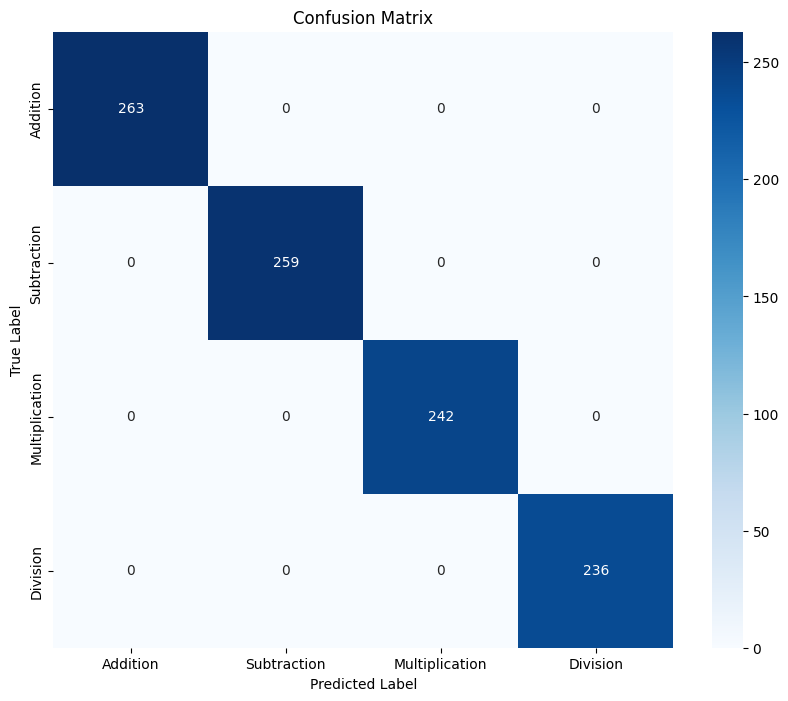

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class ArithmeticTransformer(nn.Module):
    def __init__(self, d_model=64, nhead=4, dim_feedforward=128, num_layers=2):
        super(ArithmeticTransformer, self).__init__()
        
        self.input_proj = nn.Linear(1, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, 3, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, 4)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 3, 1)
        x = self.input_proj(x)
        x = x + self.pos_embedding
        x = self.transformer(x)
        x = x[:, 0, :]
        return self.classifier(x)

def generate_data(num_samples=1000):
    X = []
    y = []
    operations = ['add', 'subtract', 'multiply', 'divide']
    
    while len(X) < num_samples:
        a = np.random.randint(-10, 11)
        b = np.random.randint(-10, 11)
        
        if b == 0:
            b = 1
        
        if a % b != 0:
            continue
        
        results = {
            'add': a + b,
            'subtract': a - b,
            'multiply': a * b,
            'divide': a / b
        }
        
        values = list(results.values())
        if len(set(values)) == len(values):
            selected_op = np.random.choice(operations)
            c = results[selected_op]
            
            X.append([a, b, c])
            y.append(operations.index(selected_op))
    
    return np.array(X), np.array(y)

def train_and_evaluate(d_model=64, nhead=4, dim_feedforward=128, num_layers=2, max_epochs=2000):
    torch.manual_seed(42)
    np.random.seed(42)
    
    model = ArithmeticTransformer(d_model, nhead, dim_feedforward, num_layers)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)
    criterion = nn.CrossEntropyLoss()
    
    X_train, y_train = generate_data(5000)
    X_val, y_val = generate_data(1000)
    X_test, y_test = generate_data(1000)
    
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)
    
    best_val_accuracy = 0
    best_model_state = None
    patience = 100
    no_improve = 0
    
    train_losses = []
    val_accuracies = []
    
    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            _, predicted = torch.max(val_outputs, 1)
            val_accuracy = (predicted == y_val_tensor).sum().item() / y_val_tensor.size(0)
            val_accuracies.append(val_accuracy)
            
            if epoch % 50 == 0:
                print(f"  Epoch {epoch}: Train Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")
            
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_model_state = model.state_dict().copy()
                no_improve = 0
            else:
                no_improve += 1
            
            if val_accuracy >= 0.999:
                print(f"✓ Target achieved at epoch {epoch+1}")
                print(f"  Validation Accuracy: {val_accuracy:.4f}")
                break
                
            if no_improve >= patience:
                print(f"× Early stopping at epoch {epoch+1}")
                print(f"  Best validation accuracy: {best_val_accuracy:.4f}")
                break
    
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, predicted = torch.max(test_outputs, 1)
        test_accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    
    return {
        'model': model,
        'epochs': epoch+1,
        'val_accuracy': best_val_accuracy,
        'test_accuracy': test_accuracy,
        'y_test': y_test,
        'y_pred': predicted.cpu().numpy()
    }

def plot_confusion_matrix(result):
    operations = ['Addition', 'Subtraction', 'Multiplication', 'Division']
    cm = confusion_matrix(result['y_test'], result['y_pred'])
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=operations, yticklabels=operations)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

d_model = 64
nhead = 4
dim_feedforward = 128
num_layers = 2

result = train_and_evaluate(d_model, nhead, dim_feedforward, num_layers)
plot_confusion_matrix(result)